## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

## Preparing Data

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [1]:
# !pip install torchtext
# !pip install spacy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

Next, we'll set the random seed for reproducability.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import spacy.cli
# spacy.cli.download("de_core_news_sm")
# spacy.cli.download("en_core_web_sm")


As before, we'll import spaCy and define the German and English tokenizers.

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [6]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

When using packed padded sequences, we need to tell PyTorch how long the actual (non-padded) sequences are. Luckily for us, TorchText's `Field` objects allow us to use the `include_lengths` argument, this will cause our `batch.src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the non-padded lengths of each source sentence within the batch.

In [7]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

We then load the data.

In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

And build the vocabulary.

In [9]:
SRC.build_vocab(train_data, min_freq = 2) #[0, 1, 2, 4]
TRG.build_vocab(train_data, min_freq = 2) #[0, 1, 3 ,4 ]
TRG.vocab.extend(SRC.vocab)

In [10]:
len(SRC.vocab), len(TRG.vocab)

(7853, 13101)

In [11]:
TRG

Next, we handle the iterators.

One quirk about packed padded sequences is that all elements in the batch need to be sorted by their non-padded lengths in descending order, i.e. the first sentence in the batch needs to be the longest. We use two arguments of the iterator to handle this, `sort_within_batch` which tells the iterator that the contents of the batch need to be sorted, and `sort_key` a function which tells the iterator how to sort the elements in the batch. Here, we sort by the length of the `src` sentence.

In [12]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [14]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)
    
    

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

hi I am 
1  0  0  0 [no of words in dict] * length of sentence 
0  1  0  0 
0  0  1  0
{hi, I , an , Raj, Sah}
I am Raj 
0  1  0  0 [no of words in dict] * length of sentence 
0  0  1  0 
0  0  0  1
 mutter trinker agua
 mother drink water

mutter earth 
mutter earth 

0 0.1 0   0   0
0 0   0.2 0   0
0 0   0   0.8 0

hi i you to <eng>
0.1 0.4 0.2 0.6
to 0 0 0 1   0
hi 1 0 0 0   0

In [15]:
class Decoder(nn.Module):
    def __init__(self, total_output_dim, gen_output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention, copy_n, device):
        super().__init__()
        
        self.total_output_dim = total_output_dim
        self.gen_output_dim = gen_output_dim
        self.attention = attention
        self.copy_n = copy_n
        self.device = device
        
        self.embedding = nn.Embedding(total_output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 4) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, gen_output_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask, prev_selective_read, one_hot_input_seq):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        seq_length = encoder_outputs.data.shape[0]
        batch_size = encoder_outputs.data.shape[1]
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a, encoder_outputs) # context
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, prev_selective_read, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
#         assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        gen_score = self.fc_out(torch.cat((output, weighted, embedded), dim = 1)) #[batch size, no of words in vocab of english] 
        
        gen_padding = torch.zeros(batch_size, self.total_output_dim - self.gen_output_dim).to(self.device)
        gen_probs = torch.cat((gen_score, gen_padding), dim=1)  # [b, vocab_size + seq_length]
        
        import pdb
#         pdb.set_trace()
        copy_score, copy_score_seq = self.copy_n(output, one_hot_input_seq, encoder_outputs)
        
        final_probs = gen_probs + copy_score
#         print(gen_probs.max(axis=1)[0][0], copy_score.max(axis=1)[0][0], copy_score.max(axis=1)[1][0], input[0][0])
        probs = F.softmax(final_probs, dim=1)

        probs = torch.log(probs + 10**-10) 
        _, topi = probs.topk(1) 

        sampled_idx = topi.view(batch_size, 1) # transpose
        
        reshaped_idxs = sampled_idx.view(-1, 1, 1).expand(one_hot_input_seq.size(1), one_hot_input_seq.size(0), 1)
        try:
            pos_in_input_of_sampled_token = one_hot_input_seq.transpose(1,0).gather(2, reshaped_idxs)  # [b, seq_length, 1]
        except:
            print("error")
            return sampled_idx, probs, hidden.squeeze(0), prev_selective_read, a.squeeze(1), copy_score
        selected_scores = pos_in_input_of_sampled_token * copy_score_seq
        selected_scores_norm = F.normalize(selected_scores, p=2)
        selective_read = (selected_scores_norm * encoder_outputs).sum(dim=1).unsqueeze(1)
        
        return sampled_idx ,probs, hidden.squeeze(0), selective_read.transpose(0,1), a.squeeze(1), copy_score

In [16]:
class CopyNet(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.dec_hid_dim = dec_hid_dim
        self.copy_W = nn.Linear(enc_hid_dim, 2 * dec_hid_dim)
        
    def forward(self, gru_output, one_hot_input_seq, encoder_outputs):
        batch_size = gru_output.shape[0]
        transformed_hidden2 = torch.tanh(self.copy_W(gru_output)).view(batch_size, 2 * self.dec_hid_dim, 1)
        copy_score_seq = torch.bmm(encoder_outputs, transformed_hidden2)  # this is linear. add activation function before multiplying.	
        copy_scores = torch.bmm(torch.transpose(copy_score_seq, 1, 2), torch.transpose(one_hot_input_seq, 0, 1)).squeeze(1)  # [b, vocab_size + seq_length]	
        return copy_scores, copy_score_seq

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [17]:
from torch.autograd import Variable

def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).contiguous().view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot, requires_grad=True) if isinstance(y, Variable) else y_one_hot
    # return y_one_hot

        [this cat has cat]   10 [cat dog pig gutter has a this]
   this => [0 0 0 0 0 0 1]
   cat  => [1 0 0 0 0 0 0]
   has =>  [0 0 0 0 1 0 0]
   cat =>  [1 0 0 0 0 0 0]

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device, DEC_HID_DIM):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        self.DEC_HID_DIM = DEC_HID_DIM
        
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):

        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.total_output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        
        input = trg[0,:]        
        mask = self.create_mask(src)
        
        selective_read = torch.zeros(1, batch_size ,self.DEC_HID_DIM * 2).to(self.device) ## ==> TODO: change to hidden unit

        import pdb
#         pdb.set_trace()
        src_new = torch.zeros_like(src)
        for k in range(src.shape[0]):
            for j in range(src.shape[1]):
                src_new[k][j] = TRG.vocab.stoi[SRC.vocab.itos[src[k][j]]]

        one_hot_input_seq = to_one_hot(src_new, trg_vocab_size).to(self.device) # [batch size, no of words in input, vocab size]

        #mask = [batch size, src len]
                
#         i = 0
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state

            sampled_idx, probs, hidden, selective_read, _, s = self.decoder(input, hidden, encoder_outputs, mask, selective_read, one_hot_input_seq)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = probs
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
             #get the highest predicted token from our predictions
#             top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            if teacher_force :
                input = trg[t] 
            else:
                input = sampled_idx.squeeze(1)
            
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

In [19]:
INPUT_DIM = len(SRC.vocab)
TOTAL_OUTPUT_DIM = len(TRG.vocab)
GEN_OUTPUT_DEM = 5893
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.2
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
copy_n = CopyNet(ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(TOTAL_OUTPUT_DIM, GEN_OUTPUT_DEM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn, copy_n, device)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device, DEC_HID_DIM).to(device)

In [20]:
dec

Decoder(
  (attention): Attention(
    (attn): Linear(in_features=1536, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (copy_n): CopyNet(
    (copy_W): Linear(in_features=512, out_features=1024, bias=True)
  )
  (embedding): Embedding(13101, 256)
  (rnn): GRU(2304, 512)
  (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [21]:
print(INPUT_DIM, TOTAL_OUTPUT_DIM, GEN_OUTPUT_DEM, ENC_EMB_DIM, DEC_EMB_DIM, SRC_PAD_IDX)

7853 13101 5893 256 256 1


Then, we initialize the model parameters.

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (copy_n): CopyNet(
      (copy_W): Linear(in_features=512, out_features=1024, bias=True)
    )
    (embedding): Embedding(13101, 256)
    (rnn): GRU(2304, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,461,829 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [24]:
optimizer = optim.Adam(model.parameters())

In [25]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
#         import pdb
#         pdb.set_trace()
        src, src_len = batch.src
        
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        # import pdb
        # pdb.set_trace()
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
#         print(i, len(iterator), epoch_loss)
        
    return epoch_loss / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model. Notice how it takes almost half the time as our model without the improvements added in this notebook.

In [29]:

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'newest.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 24s
	Train Loss: 5.341 | Train PPL: 208.820
	 Val. Loss: 4.813 |  Val. PPL: 123.087
Epoch: 02 | Time: 2m 24s
	Train Loss: 4.009 | Train PPL:  55.102
	 Val. Loss: 4.212 |  Val. PPL:  67.490
Epoch: 03 | Time: 2m 23s
	Train Loss: 3.310 | Train PPL:  27.394
	 Val. Loss: 3.712 |  Val. PPL:  40.916
Epoch: 04 | Time: 2m 21s
	Train Loss: 2.849 | Train PPL:  17.263
	 Val. Loss: 3.435 |  Val. PPL:  31.026
Epoch: 05 | Time: 2m 18s
	Train Loss: 2.517 | Train PPL:  12.388
	 Val. Loss: 3.308 |  Val. PPL:  27.324
Epoch: 06 | Time: 2m 20s
	Train Loss: 2.256 | Train PPL:   9.544
	 Val. Loss: 3.367 |  Val. PPL:  29.001
Epoch: 07 | Time: 2m 20s
	Train Loss: 2.058 | Train PPL:   7.827
	 Val. Loss: 3.257 |  Val. PPL:  25.974
Epoch: 08 | Time: 2m 20s
	Train Loss: 1.890 | Train PPL:   6.617
	 Val. Loss: 3.375 |  Val. PPL:  29.234
Epoch: 09 | Time: 2m 21s
	Train Loss: 1.746 | Train PPL:   5.734
	 Val. Loss: 3.300 |  Val. PPL:  27.114
Epoch: 10 | Time: 2m 19s
	Train Loss: 1.632 | Train PPL

Finally, we load the parameters from our best validation loss and get our results on the test set.

We get the improved test perplexity whilst almost being twice as fast!

In [29]:
model.load_state_dict(torch.load('test.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.198 | Test PPL:  24.493 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [30]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    selective_read = torch.zeros(1, 1 , DEC_HID_DIM * 2).to(device) ## ==> TODO: change to hidden unit

    src_new = torch.zeros_like(src_tensor)
    for k in range(src_tensor.shape[0]):
        for j in range(src_tensor.shape[1]):
            src_new[k][j] = TRG.vocab.stoi[SRC.vocab.itos[src_tensor[k][j]]]

    one_hot_input_seq = to_one_hot(src_new, TOTAL_OUTPUT_DIM).to(device)

    trg_tokens = []
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
#         print("input", trg_tensor.sum().item(), hidden.sum().item(), encoder_outputs.sum().item(), mask.sum().item(), selective_read.sum().item(), one_hot_input_seq.sum().item())

        with torch.no_grad():
            sampled_idx, log_probs, hidden, selective_read, attention, copy = model.decoder(trg_tensor, hidden, encoder_outputs, mask, selective_read, one_hot_input_seq)
#             output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        
#         print("ouput", trg_tensor.sum().item(), hidden.sum().item(), log_probs.sum().item(), selective_read.sum().item() , attention.sum().item() , copy.sum().item())

        attentions[i] = attention
    
        _,pred_token = log_probs.topk(1)
#         print(trg_field.vocab.itos[pred_token.item()])
        trg_indexes.append(sampled_idx)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [31]:
SRC.vocab.stoi["terrier"]

4152

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [32]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [33]:
torch.set_printoptions(profile="default") # reset

Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate, it gets the translation correct except changes *are fighting* to just *fighting*.

src = ein boston terrier läuft über saftig-grünes gras vor einem weißen zaun .
trg = a boston terrier is running on lush green grass in front of a white fence .
predicted trg = a boston terrier runs across grass grass in front of a white fence . <eos>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


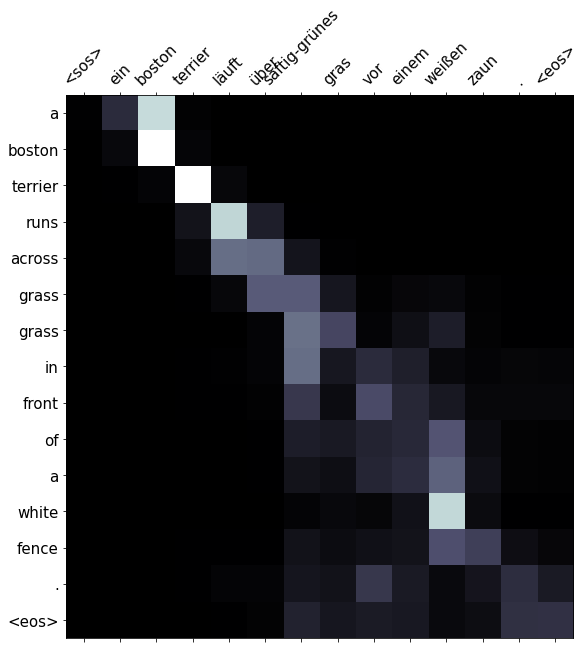

In [34]:
example_idx = 1

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

# for t in translation:
#     print(" ".join(t))
print(f'predicted trg = {" ".join(translation)}')

display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [35]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')

src = eine frau spielt ein lied auf ihrer geige .
trg = a female playing a song on her violin .


Then let's generate our translation and view the attention.

Here, we can see the translation is the same except for swapping *female* with *woman*.

predicted trg = a woman is playing a song on her . . <eos>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


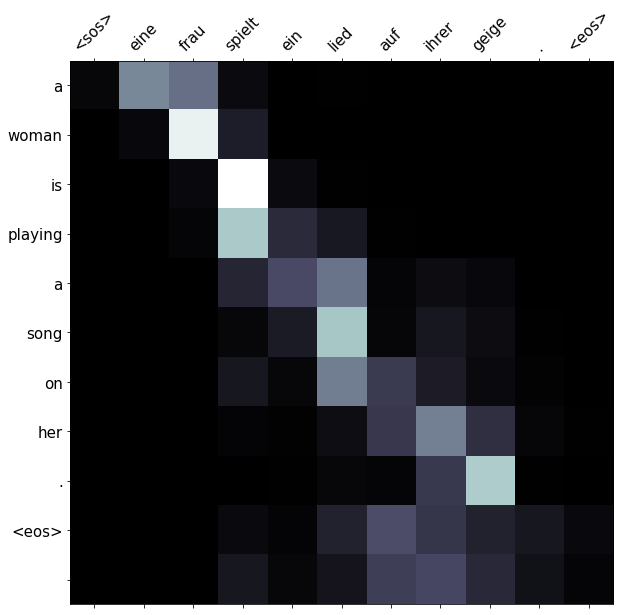

In [36]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

display_attention(src, translation[:-2] + ["<eos>"], attention)

Finally, let's get an example from the test set.

In [37]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
# src[0] = "<Najjjjj>"
print(f'src = {" ".join(src)}')
print(f'trg = {" ".join(trg)}')


src = ein brauner hund rennt dem schwarzen hund hinterher .
trg = a brown dog is running after the black dog .


Again, it produces a slightly different translation than target, a more literal version of the source sentence. It swaps *mountain climbing* for *climbing a mountain*.

predicted trg = a brown dog runs running black dog . <eos>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


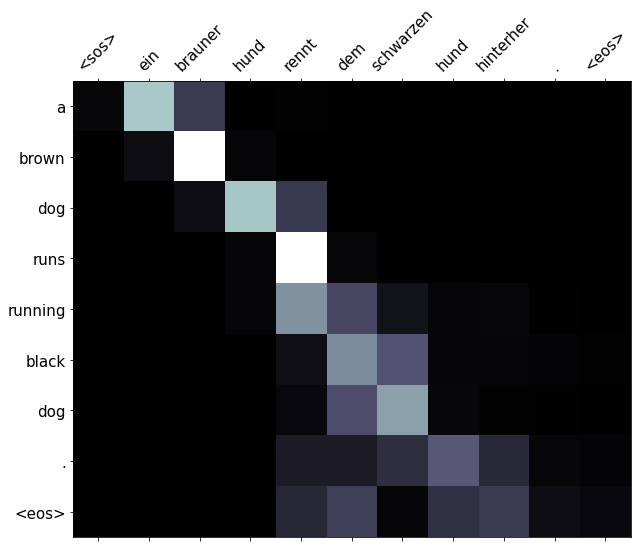

In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {" ".join(translation)}')

display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [41]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, dic, max_len = 50, beam_width=4, ):
    trgs = []
    pred_trgs = []
    i = 0
    dic[beam_width] = []
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg ,_ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        print(i, set(src).intersection(set(pred_trg)), pred_trg)
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        i+= 1
    dic[beam_width] = pred_trgs
    return dic

In [42]:
from torchtext.data.metrics import bleu_score

def get_trg(data, src_field, trg_field, model, device, dic, max_len = 50, beam_width=4, ):
    trgs = []
    pred_trgs = []
    i = 0
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
#         pred_trg = translate_sentence_beam_search(src, src_field, trg_field, model, device, max_len, beam_width)[-1]
#         print(i, set(src).intersection(set(pred_trg)), pred_trg)
#         pred_trg = pred_trg[1:-1]
        
#         pred_trgs.append(pred_trg)
        trgs.append([trg])
        i+= 1
#     dic[beam_width] = pred_trgs
    return trgs

We get a BLEU of around 28. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".

In [43]:
dic = {}
trgs = get_trg(test_data, SRC, TRG, model, device,dic, beam_width=1)

In [103]:
# for bw in range(3,10):
dic = calculate_bleu(test_data, SRC, TRG, model, device,dic, beam_width=0, )
print(bw, len(dic.keys()))



0 {'.'} ['a', 'man', 'in', 'an', 'orange', 'hat', 'is', '<unk>', 'something', '.', '<eos>']
1 {'boston', '.', 'terrier'} ['a', 'boston', 'terrier', 'runs', 'across', 'grass', 'grass', 'in', 'front', 'of', 'a', 'white', 'fence', '.', '<eos>']
2 {'.', 'in'} ['a', 'girl', 'in', 'a', 'karate', 'karate', 'uniform', 'is', 'a', 'a', 'a', 'a', '.', '.', '<eos>']
3 {'.', 'in'} ['five', 'people', 'in', 'a', 'winter', 'suits', 'and', 'and', 'helmets', 'are', 'in', 'in', 'the', 'snow', 'with', 'in', 'the', 'background', '.', '<eos>']
4 {'.'} ['people', 'are', 'fixing', 'the', 'roof', 'of', 'a', 'house', '.', '<eos>']
5 {'.', 'in', ','} ['a', 'man', 'dressed', 'in', 'a', 'is', 'a', 'a', 'group', 'of', 'men', 'in', 'a', 'black', 'and', 'white', 'dress', ',', 'with', 'a', 'woman', 'in', 'a', 'woman', '.', '<eos>']
6 {'.'} ['a', 'group', 'of', 'people', 'standing', 'in', 'front', 'of', 'a', '.', '.', '<eos>']
7 {'.', 'in', 'base'} ['a', 'boy', 'in', 'a', 'red', 'jersey', 'is', 'trying', 'to', 'hit', '

In [104]:
len(dic[0]), len(trgs)
bleu_score(dic[0], trgs)

0.2999806381521378

In the next tutorials we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next tutorial we will be using convolutional neural networks.

In [46]:

class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, logProb, length, totalSentence, encoder_outputs, selective_read):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.hidden = hiddenstate
        self.prevNode = previousNode
        self.totalSentence = totalSentence
        self.logProb = logProb
        self.length = length
        self.encoder_outputs = encoder_outputs
        self.selective_read = selective_read

    def eval(self, alpha=1.0):
        reward = 0
        # Add here a function for shaping a reward

        return self.logProb #/ float(self.length - 1 + 1e-6) + alpha * reward


In [44]:
import copy

def translate_sentence_beam_search(sentence, src_field, trg_field, model, device, max_len = 50, beam_width=4):
    
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes_queue = []
    

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    selective_read = torch.zeros(1, 1 , DEC_HID_DIM * 2).to(device) ## ==> TODO: change to hidden unit
    
    initNode = BeamSearchNode(hiddenstate=hidden,
                              previousNode="", 
                              logProb=0.0, 
                              length=1, 
                              totalSentence=[trg_field.vocab.stoi[trg_field.init_token]],
                              encoder_outputs=encoder_outputs,
                              selective_read=selective_read,
                             )
    trg_indexes_queue.append(initNode) # trg_index, score, step <sos>
    
    src_new = torch.zeros_like(src_tensor)
    for k in range(src_tensor.shape[0]):
        for j in range(src_tensor.shape[1]):
            src_new[k][j] = TRG.vocab.stoi[SRC.vocab.itos[src_tensor[k][j]]]


    one_hot_input_seq = to_one_hot(src_new, TOTAL_OUTPUT_DIM).to(device)

    trg_tokens = []
    final_pred_list = []
    step = 0
    break_flag = False
    for i in range(max_len):
        next_batch = copy.deepcopy(trg_indexes_queue)
        trg_indexes_queue = []
        if break_flag:
            break
        for node in next_batch:

            if node.totalSentence[-1] == trg_field.vocab.stoi[trg_field.eos_token]:
                final_pred_list.append(node)
                if len(final_pred_list) == beam_width:
                    break_flag = True
                    break
                continue

            trg_tensor = torch.LongTensor([node.totalSentence[-1]]).to(device)

            with torch.no_grad():
                sampled_idx, log_probs, hidden, selective_read, attention, c = model.decoder(
                    trg_tensor, 
                    node.hidden, 
                    encoder_outputs, 
                    mask, 
                    node.selective_read, 
                    one_hot_input_seq)

            scores, pred_tokens = log_probs.topk(beam_width) 
            for n in range(beam_width):
                newNode = BeamSearchNode(hiddenstate=hidden,
                              previousNode=node, 
                              logProb=node.logProb + scores[0][n].item(), 
                              length=node.length + 1, 
                              totalSentence=node.totalSentence + [pred_tokens[0][n].item()],
                              encoder_outputs=encoder_outputs,
                              selective_read=selective_read,
                             )
#                 print( [trg_field.vocab.itos[ll] for ll in newNode.totalSentence] )

                trg_indexes_queue.append(newNode)
                
        # keep only top k
        trg_indexes_queue = sorted(trg_indexes_queue, key=lambda tup:tup.eval())
#         print("i",[" ".join([trg_field.vocab.itos[index] for index in node.totalSentence])for node in trg_indexes_queue])
        trg_indexes_queue = trg_indexes_queue[-beam_width:]
#         print("o",[" ".join([trg_field.vocab.itos[index] for index in node.totalSentence])for node in trg_indexes_queue])

    final_pred_list = sorted(final_pred_list, key=lambda tup:tup.eval())
    final_pred_list = final_pred_list[-beam_width:]
    
    all_sentences = []
    for node in  final_pred_list:
        totalSentence = node.totalSentence
        sentence = []
        for index in totalSentence:
            sentence.append(trg_field.vocab.itos[index])

        all_sentences.append(sentence)
    return all_sentences

In [ ]:
for i in dic.keys():
    print(i,bleu_score(dic[i],trgs))

In [ ]:
len(dic[2]), len(trgs)

In [47]:
import copy

def translate_sentence_nucleus_sampling(sentence, src_field, trg_field, model, device, max_len = 50, temp=1, p_threshold=0.5):

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes_queue = []
    

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    selective_read = torch.zeros(1, 1 , DEC_HID_DIM * 2).to(device) ## ==> TODO: change to hidden unit
    
    initNode = BeamSearchNode(hiddenstate=hidden,
                              previousNode="", 
                              logProb=0.0, 
                              length=1, 
                              totalSentence=[trg_field.vocab.stoi[trg_field.init_token]],
                              encoder_outputs=encoder_outputs,
                              selective_read=selective_read,
                             )
    trg_indexes_queue.append(initNode) # trg_index, score, step <sos>
    
    src_new = torch.zeros_like(src_tensor)
    for k in range(src_tensor.shape[0]):
        for j in range(src_tensor.shape[1]):
            src_new[k][j] = TRG.vocab.stoi[SRC.vocab.itos[src_tensor[k][j]]]


    one_hot_input_seq = to_one_hot(src_new, TOTAL_OUTPUT_DIM).to(device)

    trg_tokens = []
    final_pred_list = []
    step = 0

    for i in range(max_len):
        next_batch = copy.deepcopy(trg_indexes_queue)
        trg_indexes_queue = []
        for node in next_batch:

            if node.totalSentence[-1] == trg_field.vocab.stoi[trg_field.eos_token]:
                final_pred_list.append(node)
                continue

            trg_tensor = torch.LongTensor([node.totalSentence[-1]]).to(device)

            with torch.no_grad():
                sampled_idx, log_probs, hidden, selective_read, attention, c = model.decoder(
                    trg_tensor, 
                    node.hidden, 
                    encoder_outputs, 
                    mask, 
                    node.selective_read, 
                    one_hot_input_seq)
            
            predictedNormProb = log_probs[0].div(temp).exp()
            sorted_probs, sorted_indices = torch.sort(predictedNormProb, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=0)
            sorted_indices_to_remove = cumulative_probs < p_threshold
            if len(sorted_indices[sorted_indices_to_remove]) == 0:
                pred_tokens = [sorted_indices[0]]
                scores = [sorted_probs[0]]
            else:      
                pred_tokens = sorted_indices[sorted_probs[:len(sorted_indices_to_remove)].multinomial(1)]
                scores = []
                for token in pred_tokens:
                    scores.append(log_probs[0][token])
                
            for n in range(len(pred_tokens)):
                newNode = BeamSearchNode(hiddenstate=hidden,
                              previousNode=node, 
                              logProb=node.logProb + scores[n].item(), 
                              length=node.length + 1, 
                              totalSentence=node.totalSentence + [pred_tokens[n].item()],
                              encoder_outputs=encoder_outputs,
                              selective_read=selective_read,
                             )
#                 print( [trg_field.vocab.itos[ll] for ll in newNode.totalSentence] )

                trg_indexes_queue.append(newNode)
        
    assert len(final_pred_list) == 1
    
    return [TRG.vocab.itos[ll] for ll in final_pred_list[0].totalSentence]


In [48]:
translate_sentence_nucleus_sampling(src, SRC, TRG, model, device)


['<sos>',
 'a',
 'brown',
 'dog',
 'runs',
 'in',
 'black',
 'dog',
 'is',
 '.',
 '<eos>']

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_(data, src_field, trg_field, model, device, dic, max_len = 50, p_threshold = 0.5 ):
    trgs = []
    pred_trgs = []
    i = 0
    dic[p_threshold] = []
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg = translate_sentence_nucleus_sampling(src, src_field, trg_field, model, device, max_len, p_threshold)
        print(i, " ".join(pred_trg[1:-1]), p_threshold)
        pred_trg = pred_trg[1:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        i+= 1
    dic[p_threshold] = pred_trgs
    return dic

In [ ]:
dic = {}
for i in range(1,11):
    p_thresh = i * 1.0 / 10.0
    dic = calculate_bleu_(test_data, SRC, TRG, model, device, dic, max_len=50, p_threshold=p_thresh)

In [ ]:
for i in dic.keys():
    print(i,bleu_score(dic[i],trgs))

In [ ]:
for i, t in enumerate(trgs):
    print(i, " ".join(t[0]))